In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.ma.core import append
from scipy.constants import epsilon_0
from scipy.stats import linregress
from scipy.optimize import curve_fit
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [2]:
df = pd.read_excel("./data/Projet_I2M_2020-2021.xls")


# Initialize variables for cycle detection
cycle_number = 0
cycle_list = []
found_max = False  # Tracks if we've found the maximum
found_min = False  # Tracks if we've found the minimum

# Calculate the derivative of the strain and fill the first NaN value with 0
df['Strain_Derivative'] = df['Déformation'].diff().fillna(0)

# Iterate over the strain values and their derivatives
for i in range(1, len(df)):  # Start from index 1 to have a valid derivative
    strain_current = df['Déformation'].iloc[i]
    derivative_previous = df['Strain_Derivative'].iloc[i - 1]
    derivative_current = df['Strain_Derivative'].iloc[i]

    # Detect maxima (when derivative changes from positive to negative)
    if derivative_previous > 0 and derivative_current < 0:
        found_max = True

    # Detect minima (when derivative changes from negative to positive)
    if derivative_previous < 0 and derivative_current > 0 and found_max:
        found_min = True

    # Complete the cycle when both a maximum and minimum have been found
    if found_max and found_min and (df['Déformation'].iloc[i-1] * df['Déformation'].iloc[i]) < 0:
        cycle_number += 1
        found_max = False  # Reset for the next cycle
        found_min = False  # Reset for the next cycle

    # Append the current cycle number
    cycle_list.append(cycle_number)

# Ensure the first row also gets the initial cycle number
cycle_list = [0] + cycle_list

# Add the cycle list to the DataFrame
df['Cycle'] = cycle_list[:len(df)]  # Ensure the lengths match

df["stress_derivative"] = df["Contrainte (MPa)"].diff()

# Data analysing

Text(0.5, 1.0, 'Strain vs. Stress for the first cycle')

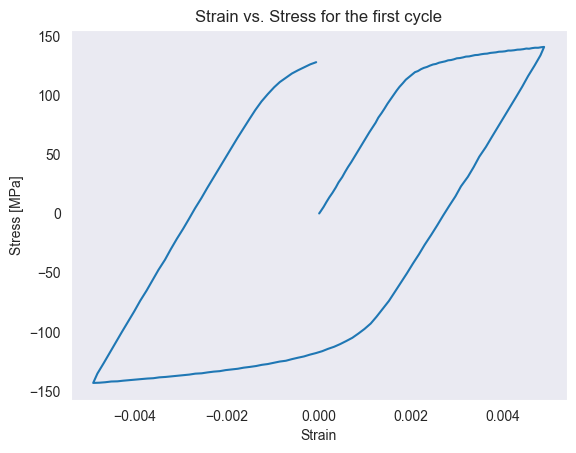

In [3]:
plt.plot(df[df["Cycle"]==0]["Déformation"], df[df["Cycle"]==0]["Contrainte (MPa)"])
plt.grid()
plt.xlabel("Strain")
plt.ylabel("Stress [MPa]")
plt.title("Strain vs. Stress for the first cycle")

In [4]:
def get_sigma_y(df, lim=2):
    deformation = df["Déformation"]
    stress = df["Contrainte (MPa)"]
    
    # Linear fit for the elastic region (assuming strain < 0.002 is elastic)
    elastic_region = df[deformation < 0.002]
    slope, intercept, _, _, _ = linregress(elastic_region["Déformation"], elastic_region["Contrainte (MPa)"])
    
    # Calculate the predicted stress based on the elastic fit
    predicted_stress = slope * deformation + intercept
    
    # Find the point where the curve deviates significantly (plastic region starts)
    deviation = np.abs(stress - predicted_stress)
    yield_index = deviation[deviation > lim].idxmin()  # Identify index of maximum deviation
    
    sigma_y = stress.loc[yield_index]  # Yield stress value
    strain_y = deformation.loc[yield_index]  # Strain at yield
    
    return sigma_y, strain_y, deformation, predicted_stress, slope

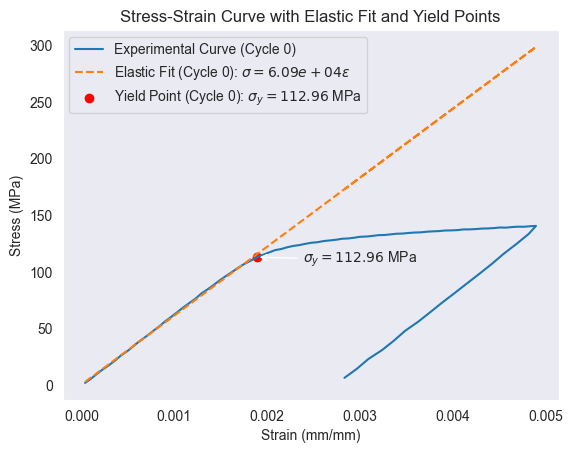

In [25]:
# First Yield Point and Elastic Fit (Cycle 0)
sigma_y, strain_y, deformation, predicted_stress, E = get_sigma_y(
    df[(df["Cycle"] == 0) & (df["Déformation"] > 0) & (df["Contrainte (MPa)"] > 0)]
)

# Plot the experimental stress-strain curve for Cycle 0
plt.plot(
    df[(df["Cycle"] == 0) & (df["Déformation"] > 0) & (df["Contrainte (MPa)"] > 0)]["Déformation"],
    df[(df["Cycle"] == 0) & (df["Déformation"] > 0) & (df["Contrainte (MPa)"] > 0)]["Contrainte (MPa)"],
    label="Experimental Curve (Cycle 0)"
)

# Plot the elastic fit curve
plt.plot(
    deformation, predicted_stress, 
    label=rf'Elastic Fit (Cycle 0): $\sigma={E:.2e}\varepsilon$', linestyle='--'
)

# Highlight and annotate the first yield point (\sigma_y)
plt.scatter(strain_y, sigma_y, color='red', label=rf'Yield Point (Cycle 0): $\sigma_y={sigma_y:.2f}$ MPa')
plt.annotate(
    rf'$\sigma_y={sigma_y:.2f}$ MPa', 
    xy=(strain_y, sigma_y), 
    xytext=(strain_y + 0.0005, sigma_y - 5),
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10
)

sigma_y0 = sigma_y
strain_y0 = strain_y
epsilon_p0 = deformation.iloc[-1]
# Add labels, title, legend, and grid
plt.xlabel("Strain (mm/mm)")
plt.ylabel("Stress (MPa)")
plt.title("Stress-Strain Curve with Elastic Fit and Yield Points")
plt.legend()
plt.grid()

# Show the plot
plt.show()


In [6]:
def get_sigma_cycle(x, y, strain, stress, slope, lim):
    """
    Calculate the yield point (sigma_y and strain_y) based on the deviation 
    of the stress-strain curve from the elastic fit.
    
    Parameters:
        x (Series): Subset of strain values for fitting (independent variable).
        y (Series): Subset of stress values for fitting (dependent variable).
        strain (Series): Full strain values for deviation calculation.
        stress (Series): Full stress values for deviation calculation.
        slope (float): Elastic modulus (slope of the elastic line).
        lim (float): Threshold for significant deviation to identify the yield point.

    Returns:
        sigma_y (float): Yield stress value.
        strain_y (float): Strain value at the yield point.
        intercept (float): Calculated y-intercept of the elastic fit.
    """
    # Calculate the y-intercept (b) for the elastic fit
    intercept = np.mean(y) - slope * np.mean(x)

    # Calculate the deviation of the stress from the elastic fit
    deviation = np.abs(stress - (slope * strain + intercept))

    # Find the first point where the deviation exceeds the threshold
    yield_indices = deviation[deviation > lim].index
    if not yield_indices.empty:
        yield_index = yield_indices[0]  # Use the first index exceeding the threshold
    else:
        raise ValueError("No significant deviation found; adjust the 'lim' parameter.")

    sigma_y = stress.loc[yield_index]  # Yield stress
    strain_y = strain.loc[yield_index]  # Yield strain

    return sigma_y, strain_y, intercept

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure sigma_y0, strain_y0, cycle_number, df, and E are defined
# List to store yield points
sigma_tab = [
    {
        "Sigma_y": sigma_y0,
        "Strain_y": strain_y0,
        "Cycle": 1,
        "epslilon_p": epsilon_p0 - strain_y0
    }
]

for i in list(range(2, 8)) + list(range(10, cycle_number)):
    plt.figure()

    # Filter the DataFrame for the current and previous cycle
    plotdf = df[
        ((df["Cycle"] == i - 1) & (df["stress_derivative"] > 0) & (df["Déformation"] < 0)) |
        ((df["Cycle"] == i) & (df["stress_derivative"] > 0) & (df["Déformation"] > 0))
    ]

    # Subset data for the elastic fit (example condition: strain < -0.003)
    subset = plotdf[plotdf["Déformation"] < -0.003]

    # Calculate Yield Point and Elastic Fit
    sigma_y, strain_y, intercept = get_sigma_cycle(
        subset["Déformation"],
        subset["Contrainte (MPa)"],
        plotdf["Déformation"],
        plotdf["Contrainte (MPa)"],
        E,
        15
    )

    # Plot the experimental stress-strain curve
    scatter = plt.scatter(
        plotdf["Déformation"],
        plotdf["Contrainte (MPa)"],
        label=f"Experimental Curve (Cycle {i})",
        s=5,
        c=plotdf["Cycle"],
        cmap="viridis"
    )

    # Add a color bar for cycle numbers
    plt.colorbar(scatter, label="Cycle Number")

    # Plot the elastic fit curve
    plt.plot(
        plotdf["Déformation"], E * plotdf["Déformation"] + intercept,
        label=rf'Elastic Fit (Cycle {i}): $\sigma={E:.2e}\varepsilon$',
        linestyle='--'
    )

    # Highlight and annotate the yield point
    plt.scatter(strain_y, sigma_y, color='red', label=rf'Yield Point (Cycle {i}): $\sigma_y={sigma_y:.2f}$ MPa')
    plt.annotate(
        rf'$\sigma_y={sigma_y:.2f}$ MPa',
        xy=(strain_y, sigma_y),
        xytext=(strain_y + 0.0005, sigma_y - 5),
        arrowprops=dict(facecolor='black', arrowstyle='->'),
        fontsize=10
    )

    # Append the yield point data to sigma_tab
    try:
        last_deformation = plotdf["Déformation"].iloc[-1]  # Get the last deformation value safely
        sigma_tab.append(
            {
                "Sigma_y": sigma_y,
                "Strain_y": strain_y,
                "Cycle": i,
                "epslilon_p": last_deformation - strain_y
            }
        )
    except IndexError:
        # Handle cases where `plotdf` is empty
        sigma_tab.append(
            {
                "Sigma_y": sigma_y,
                "Strain_y": strain_y,
                "Cycle": i,
                "epslilon_p": None
            }
        )

    # Add labels, legend, and grid
    plt.xlabel("Strain (mm/mm)")
    plt.ylabel("Stress (MPa)")
    plt.title(f"Stress-Strain Curve with Elastic Fit and Yield Points (Cycle {i})")
    plt.legend()
    plt.grid()

    # Save the plot as a PNG file
    plt.savefig(f"fig/{i}.png")
    plt.close()

# Convert sigma_tab to a DataFrame
sigma_tab = pd.DataFrame(sigma_tab)

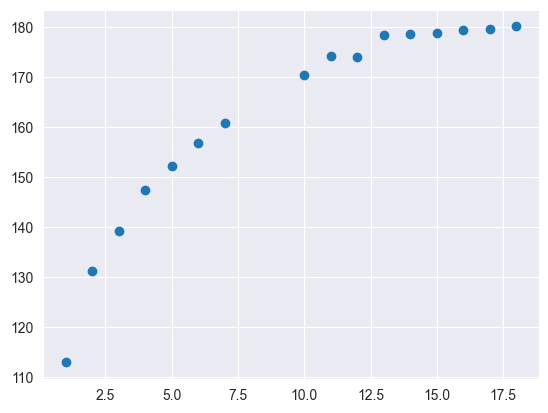

In [33]:
sigma_tab["R"] = sigma_tab["Sigma_y"] - sigma_tab["Sigma_y"][0]
sigma_tab["p"] = sigma_tab["epslilon_p"].cumsum()
plt.scatter(sigma_tab["Cycle"],sigma_tab["Sigma_y"])

In [34]:
sigma_tab

,Sigma_y,Strain_y,Cycle,epslilon_p,R,p
0,112.955763,0.001891,1,0.000944,0.000000,0.000944
1,131.222497,-0.000041,2,0.004847,18.266734,0.005790
2,139.231834,0.000236,3,0.004582,26.276071,0.010372
3,147.380000,0.000516,4,0.004319,34.424237,0.014691
4,152.191841,0.000664,5,0.004186,39.236078,0.018877
5,156.734664,0.000811,6,0.004058,43.778901,0.022936
6,160.819994,0.000957,7,0.003927,47.864231,0.026863
7,170.384711,0.001293,10,0.003539,57.428948,0.030402
8,174.097725,0.001441,11,0.003407,61.141962,0.033809
9,174.030621,0.001457,12,0.003405,61.074858,0.037214


Text(0, 0.5, '$R$ (MPa)')

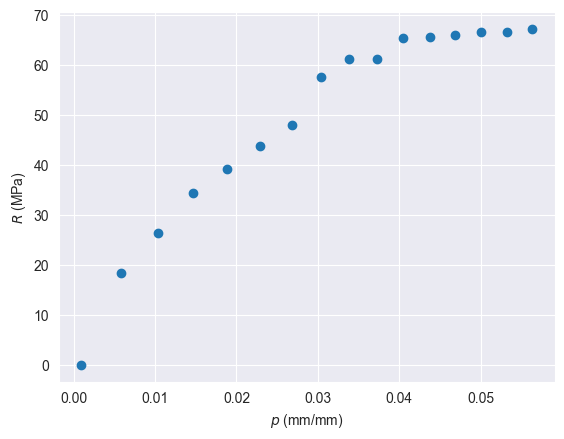

In [37]:
plt.scatter(sigma_tab["p"], sigma_tab["R"])
plt.xlabel(r"$p$ (mm/mm)")
plt.ylabel(r"$R$ (MPa)")

In [68]:
# Define the Chaboche model
def chaboche_model(p, Q, b):
    return Q * (1 - np.exp(-b * p))

# Define weights properly
# Assuming sigma_tab is a dictionary with keys "p" (plastic strain) and "R" (hardening stress)
n_assymp = 4

weights = np.array([1] * (len(sigma_tab["p"]) - n_assymp) + [10] * n_assymp)

# Perform curve fitting with weights
params, covariance = curve_fit(
    chaboche_model,
    sigma_tab["p"],
    sigma_tab["R"],
    sigma=1 / weights
)

# Extract fitted parameters
Q_fit, b_fit = params

# Generate data for the fitted curve
p_fit = np.linspace(0, max(sigma_tab["p"]), 100)
R_fit = chaboche_model(p_fit, Q_fit, b_fit)

In [69]:
weights

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 10, 10, 10, 10])

(0.0, 71.03235350353192)

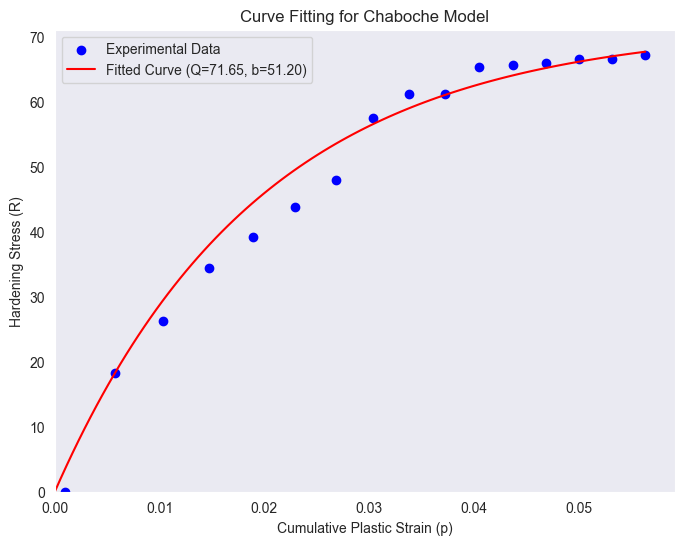

In [70]:
# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(sigma_tab["p"], sigma_tab["R"], label='Experimental Data', color='blue')
plt.plot(p_fit, R_fit, label=f'Fitted Curve (Q={Q_fit:.2f}, b={b_fit:.2f})', color='red')
plt.xlabel('Cumulative Plastic Strain (p)')
plt.ylabel('Hardening Stress (R)')
plt.title('Curve Fitting for Chaboche Model')
plt.legend()
plt.grid()
plt.xlim(0)
plt.ylim(0)

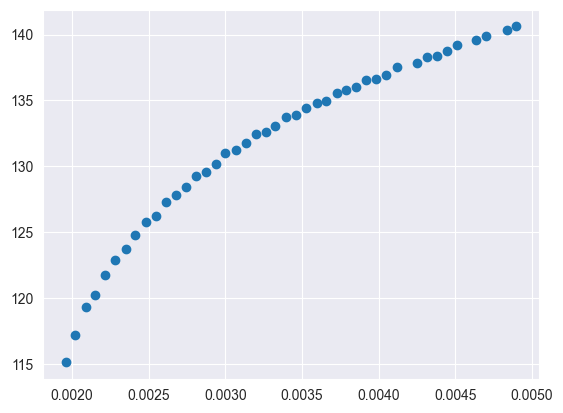

In [73]:
plt.scatter(
    df[(df["Cycle"] == 0) & (df["Déformation"] > 0) & (df["Contrainte (MPa)"] > sigma_y0) & (df["stress_derivative"] > 0)]["Déformation"],
    df[(df["Cycle"] == 0) & (df["Déformation"] > 0) & (df["Contrainte (MPa)"] > sigma_y0) & (df["stress_derivative"] > 0)]["Contrainte (MPa)"],
    label="Experimental Curve (Cycle 0)"
)

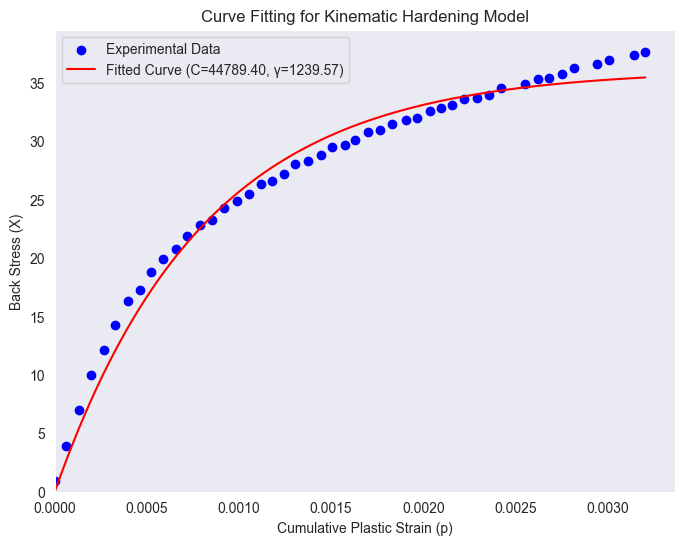

Fitted parameters: C = 44789.40, γ = 1239.57


In [101]:
# Filter data based on given conditions
data_X = df[(df["Cycle"] == 0) & 
            (df["Déformation"] > 0) & 
            (df["Contrainte (MPa)"] > sigma_y0 - 10) & 
            (df["stress_derivative"] > 0)]

# Define X_kinematic and p_kinematic
X_kinematic = data_X["Contrainte (MPa)"] - (sigma_y0 - 10)
p_kinematic = data_X["Déformation"] - data_X["Déformation"].iloc[0]  # Correct use of iloc

# Define the kinematic hardening model
def kinematic_hardening(p, gamma, C):
    return (C / gamma) * (1 - np.exp(-gamma * p))

# Perform curve fitting
params2, covariance = curve_fit(
    kinematic_hardening,
    p_kinematic,
    X_kinematic,
    bounds=([0, 0], [np.inf, np.inf])  # Ensure positive gamma and C
)

# Extract fitted parameters
gamma_fit, C_fit = params2

# Generate data for the fitted curve
p_fit = np.linspace(0, max(p_kinematic), 100)
X_fit = kinematic_hardening(p_fit, gamma_fit, C_fit)

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(p_kinematic, X_kinematic, label='Experimental Data', color='blue')
plt.plot(p_fit, X_fit, label=f'Fitted Curve (C={C_fit:.2f}, γ={gamma_fit:.2f})', color='red')
plt.xlabel('Cumulative Plastic Strain (p)')
plt.ylabel('Back Stress (X)')
plt.title('Curve Fitting for Kinematic Hardening Model')
plt.legend()
plt.grid()
plt.xlim(0)
plt.ylim(0)
plt.show()

# Output the fitted parameters
print(f"Fitted parameters: C = {C_fit:.2f}, γ = {gamma_fit:.2f}")


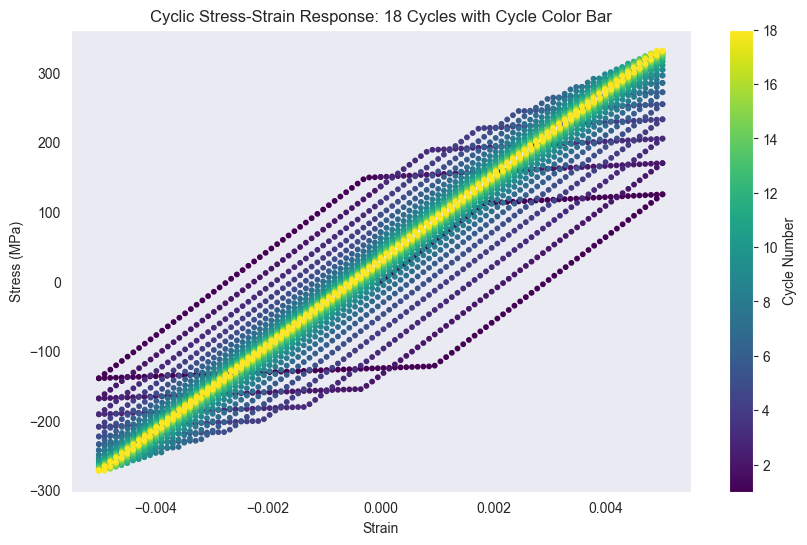

In [113]:
def simulate_cyclic_loading(strain_cycles, Q_fit, b_fit, C_fit, gamma_fit, sigma_y0, E):
    stress = []
    strain_plastic = 0.0  # Initial plastic strain
    back_stress = 0.0  # Initial back stress
    hardening_stress = 0.0  # Initial isotropic hardening stress

    for strain in strain_cycles:
        # Elastic trial stress
        trial_stress = E * (strain - strain_plastic)

        # Check yield condition
        if abs(trial_stress - back_stress) > (sigma_y0 + hardening_stress):
            # Plastic loading: compute plastic strain increment
            delta_p = (abs(trial_stress - back_stress) - sigma_y0 - hardening_stress) / E
            
            # Update plastic strain
            strain_plastic += np.sign(trial_stress - back_stress) * delta_p
            
            # Update back stress (kinematic hardening)
            back_stress += kinematic_hardening(delta_p, C_fit, gamma_fit)
            
            # Update hardening stress (isotropic hardening using Chaboche model)
            hardening_stress += chaboche_model(delta_p, Q_fit, b_fit)
        
        # Compute final stress
        stress.append(E * (strain - strain_plastic) + back_stress)

    return stress

# Generate strain cycles for 18 cycles between -0.005 and +0.005
num_cycles = 18
strain_amplitude = 0.005
points_per_half_cycle = 50

# Create strain values for one full cycle
strain_one_cycle = np.concatenate([
    np.linspace(0, strain_amplitude, points_per_half_cycle),  # Loading
    np.linspace(strain_amplitude, -strain_amplitude, 2 * points_per_half_cycle),  # Unloading & reverse loading
    np.linspace(-strain_amplitude, 0, points_per_half_cycle)  # Return to zero
])

# Repeat for 18 cycles
strain_cycles = np.tile(strain_one_cycle, num_cycles)

# Simulate stress response
stress_simulated = simulate_cyclic_loading(strain_cycles, Q_fit, b_fit, C_fit, gamma_fit, sigma_y0, E)

# Assign cycle numbers to each data point
cycle_numbers = np.repeat(np.arange(1, num_cycles + 1), len(strain_one_cycle))

# Plot results with color bar
plt.figure(figsize=(10, 6))
sc = plt.scatter(strain_cycles, stress_simulated, c=cycle_numbers, cmap='viridis', s=10, label="Simulated Data")
plt.colorbar(sc, label="Cycle Number")  # Add color bar
plt.xlabel("Strain")
plt.ylabel("Stress (MPa)")
plt.title("Cyclic Stress-Strain Response: 18 Cycles with Cycle Color Bar")
plt.grid()
plt.savefig("sim.png")

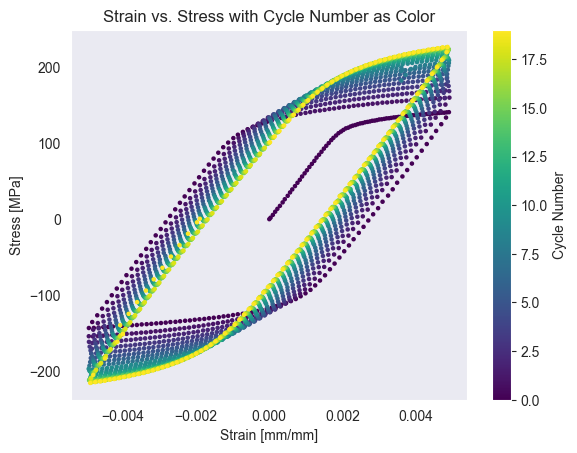

In [10]:
# Scatter plot with the cycle number as the hue (color)
scatter = plt.scatter(df["Déformation"], df["Contrainte (MPa)"], c=df['Cycle'], cmap='viridis', s=5)

# Add color bar to the plot
plt.colorbar(scatter, label='Cycle Number')

# Label the axes
plt.xlabel("Strain [mm/mm]")
plt.ylabel("Stress [MPa]")

# Set title
plt.title('Strain vs. Stress with Cycle Number as Color')
plt.grid()

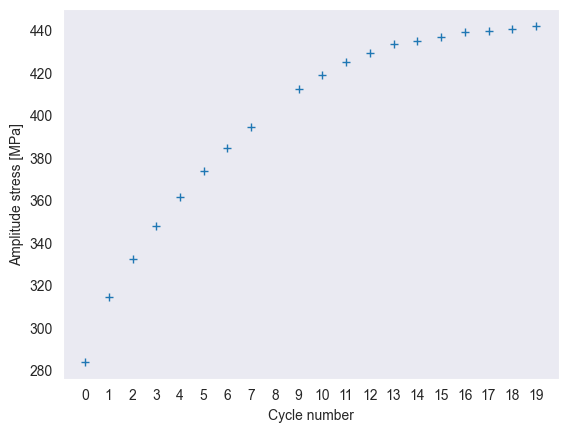

In [11]:
data2plot = []
for cycle in np.unique(df["Cycle"]):
    if cycle != 8:
        data2plot.append([
            cycle, 
            df[df["Cycle"]==cycle]["Contrainte (MPa)"].max() - df[df["Cycle"]==cycle]["Contrainte (MPa)"].min()
        ])
data2plot = np.array(data2plot)

plt.plot(data2plot[:,0], data2plot[:,1], "+")
plt.xlabel("Cycle number")
plt.ylabel("Amplitude stress [MPa]")
plt.grid()
plt.xticks([i for i in range(20)]);


(np.float64(-0.004915687835942088), np.float64(0.004912150999740038))

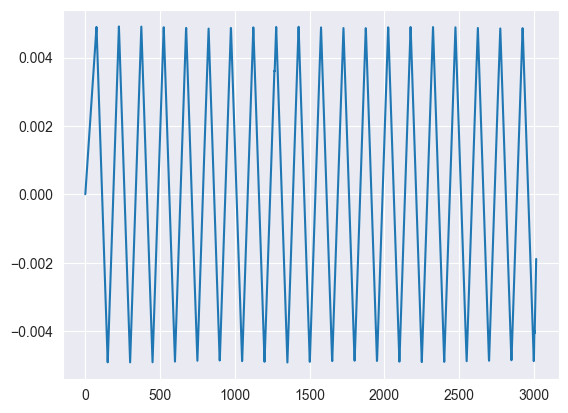

In [107]:
plt.plot(df["Déformation"])

df["Déformation"].min(), df["Déformation"].max()